In [2]:
import tensorflow as tf
tf.__version__
from tensorflow import keras

In [3]:
tf.debugging.set_log_device_placement(False)

In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from time import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [46]:
data = pd.read_csv("product_views_unified.csv")
data = data.drop_duplicates()
print(data.shape)

# grouping the data by user into an UNORDERED list (poradi ve kterem se dival na veci zanedbame)
# astype string because otherwise word2vec doesn't work


data_grouped = data.astype(str).groupby("user_id_anon")["product_id"].apply(list)

data_word_counts = data.astype(str).groupby("user_id_anon")["product_id"].apply(len)

data_word_counts.describe()

In [93]:
#import pickle
#data_grouped = pickle.load( open( "data_grouped_30.p", "rb" ) )

In [94]:
 # get the embedding matrix from word2vec:
size = 200 # 200

w2v_model = Word2Vec(min_count=20, # 1 retains all the words. different value needs some tweaking the network afterwards!!! 10 zni ok...50?
                     window=2,
                     size=size,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=4)

t = time()
w2v_model.build_vocab(data_grouped.to_numpy(), progress_per=1000000) # 
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.56 mins


In [95]:
# get the vocabulary
vocab = dict([(k, v.index) for k, v in w2v_model.wv.vocab.items()])

In [96]:
# embed the products using the vocabulary
dummy = list(vocab.keys())
lst = []
for seq in tqdm(data_grouped):
    kek = []
    for product in seq:
        try:
            kek.append(vocab[product])
            #kek.append(product)
            
        except KeyError:
            pass
    lst.append(kek)
            
data_grouped_embedded = np.array(lst)

100%|██████████| 254764/254764 [00:06<00:00, 36751.88it/s]


In [97]:
# we use the same train data and label generation as in the guide:
# create sequences of words of fixed length and the next word in the sequence is the label, example:
#[1 2 3 4 5] [6]
#[2 3 4 5 6] [7]

features = []
labels = []

training_length = 10 # 5 ok, 10 lepsi

# Iterate through the sequences of tokens
for seq in tqdm(data_grouped_embedded):

    # Create multiple training examples from each sequence
    for i in range(training_length, len(seq)):
        
        # Extract the features and label
        extract = seq[i - training_length:i + 1]

        # Set the features and label
        features.append(extract[:-1]) # train vector, tj. X
        labels.append(extract[-1]) # label, tj. y 
        
features = np.array(features)

100%|██████████| 254764/254764 [00:21<00:00, 11991.26it/s]


In [98]:
# label encoding labelu neni treba diky word2vec vocabulary embeddedingu. 
# ted uz jen one hot encodnout labels

#from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#le = LabelEncoder()

#label_labels = le.fit_transform(np.array(labels, dtype=np.int32))

ohe = OneHotEncoder()



#####ohe_labels = ohe.fit_transform(np.array(labels).reshape(-1,1))

In [99]:
vocab_list = list(vocab.values())

In [100]:
dummy = labels + vocab_list

In [101]:
ohe_all = ohe.fit_transform(np.array(dummy).reshape(-1,1))

In [102]:
ohe_labels = ohe_all[:len(labels),:]

In [103]:
type(ohe_labels)

scipy.sparse.csr.csr_matrix

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(
    features, ohe_labels, test_size=0.2, random_state=42)

In [105]:
tf.keras.backend.clear_session()

tf.config.set_soft_device_placement(False) # False lepsi



model = Sequential()
# weight matrix z word2vec pred training w2v modelu
weights = w2v_model.wv.vectors
print("weights shape: ", w2v_model.wv.vectors.shape)

#model.add(
#    tf.keras.layers.Input(
#            shape=[5,], batch_size=None,
#    )
#)

# Embedding layer
model.add(
    Embedding(input_dim=weights.shape[0],
              input_length=training_length,
              output_dim=weights.shape[1], 
              weights=[weights],
              trainable=False,
              mask_zero=True,
    )
)

# Masking layer for pre-trained embeddings
model.add(
    Masking(mask_value=0.0)
)

# Recurrent layer


model.add(
    LSTM(
        16,batch_input_shape=[None, training_length],
        return_sequences=False,
        dropout=0.1, 
        recurrent_dropout=0, # 0 misto 0.1 brutalne zrychluje protoze muzeme pouzivat non-generic gpu kernel
        stateful=False,
    )
)

# Fully connected layer
#model.add(
#    Dense(16, activation='relu') # ubereme tuhle vrstvu...treba bude lepsi?
#)

# Dropout for regularization
model.add(
    Dropout(0.5)
)

# Output layer
model.add(
    Dense(len(vocab), activation='softmax')
)


# Create callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5), # val_loss 5
    ModelCheckpoint('LSTM.h5', save_best_only=True, save_weights_only=False)
]

    # Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam'),
# ruzne optimizery, adam nejlepsi zatim s velkou learning rate 0.01...chova se hodne divne
#'adam',
#tf.keras.optimizers.Adagrad(learning_rate=0.1, initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad'),
#tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam'),
#tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.0, nesterov=False, name='SGD'),

    loss=tf.keras.losses.sparse_categorical_crossentropy,#'sparse_categorical_crossentropy', #  'categorical_crossentropy'
    metrics=['sparse_categorical_accuracy'] # 'accuracy'
)

    #model._make_predict_function()
    #model._make_test_function()
    #model._make_train_function()

model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Number of devices: 4
weights shape:  (122644, 200)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           24528800  
_________________________________________________________________
masking (Masking)            (None, 20, 200)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                13888     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 122644)            2084948   
Total params: 26,627,636
Trainable params: 2,098,836
Non-trainable params: 24,528,800
_________________________________________________________________


In [ ]:
#GLOBAL_BATCH_SIZE = 4096
EPOCHS = 200
# tf.data.Dataset struktury pro rychle zpracovani dat
dataset = tf.data.Dataset.from_tensor_slices((X_train.astype(np.int32), np.asarray(y_train.astype(np.bool).tocoo().col).reshape(-1,1))) # added reshape(-1,1) for sparse_categorial_crossentropy .reshape(-1,training_length,1)
dataset = dataset.shuffle(buffer_size=len(X_train))
dataset = dataset.repeat()
dataset = dataset.batch(GLOBAL_BATCH_SIZE, drop_remainder=False)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # 

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid.astype(np.int32), np.asarray(y_valid.astype(np.bool).tocoo().col).reshape(-1,1))) # .reshape(-1,training_length,1)
valid_dataset = valid_dataset.shuffle(buffer_size=len(X_valid))
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(GLOBAL_BATCH_SIZE, drop_remainder=False)
valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE) # 
# fit, potom pouzit historii k vyploteni chovani velicin behem epoch
history = model.fit(
    dataset,
    steps_per_epoch=int(X_train.shape[0] / GLOBAL_BATCH_SIZE) + 1,
    epochs=EPOCHS, 
    callbacks=callbacks,
    verbose=1,
    validation_data=valid_dataset,
    validation_steps=int(X_valid.shape[0] / GLOBAL_BATCH_SIZE) + 1,
)

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
342/342 [==============================] - ETA: 0s - loss: 11.6759 - sparse_categorical_accuracy: 8.4004e-04WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f1cfd6fcae8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [78]:
import matplotlib.pyplot as plt

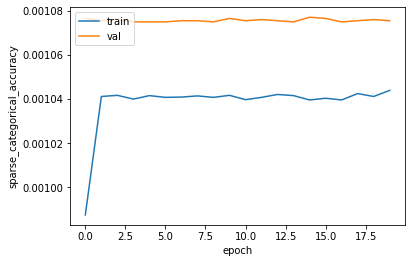

In [89]:
plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
#plt.title('Model accuracy - '+file_name+' (max '+str(max_val_acc)+')')
plt.ylabel('sparse_categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig(file_name+'_acc.eps', format = 'eps')
plt.show()

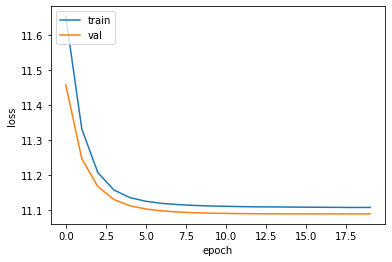

In [90]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Model accuracy - '+file_name+' (max '+str(max_val_acc)+')')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig(file_name+'_acc.eps', format = 'eps')
plt.show()

In [185]:
# load in model and evalueate on validation data
#model = tf.keras.load_model('LSTM.h5')
model.evaluate(X_valid, np.asarray(y_valid.astype(np.bool).tocoo().col))

116/116 [==============================] - 16s 137ms/step - loss: 10.4881 - sparse_categorical_accuracy: 0.0030


[10.488059997558594, 0.003049127059057355]